First import necessary packages.

In [36]:
import tensorflow as tf
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorboard import notebook
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

import time
import datetime

LOG_DIR = f"{int(time.time())}"

import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import expand_dims

import shap

Set image size and batch size across the board for later use.

In [4]:
image_size = (200, 200)
batch_size = 32

Collect train Dataset from directory, with a set parameters.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "FighterOrCivil",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)


Found 12478 files belonging to 2 classes.
Using 9983 files for training.


Collect validation Dataset from directory, with a set parameters.

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "FighterOrCivil",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 12478 files belonging to 2 classes.
Using 2495 files for validation.


Plot out a collection of train dataset images with classification.

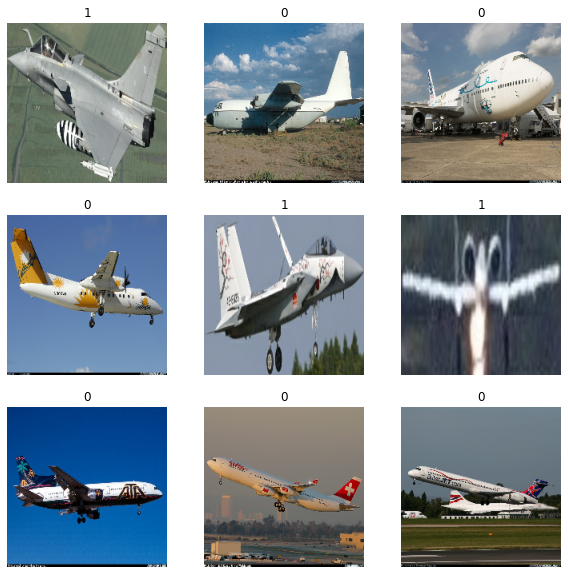

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)        
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Because the Airline Dataset has a black bar at the end of the bottom, we want to crop and resize the Airline images before we begin.

To prevent overfitting we augment the images by flipping and rotating.

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        layers.CenterCrop(185,190), #Cropping the black bar out of the pictures
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),          
    ]
)

Plot to show the augmentation of an image.

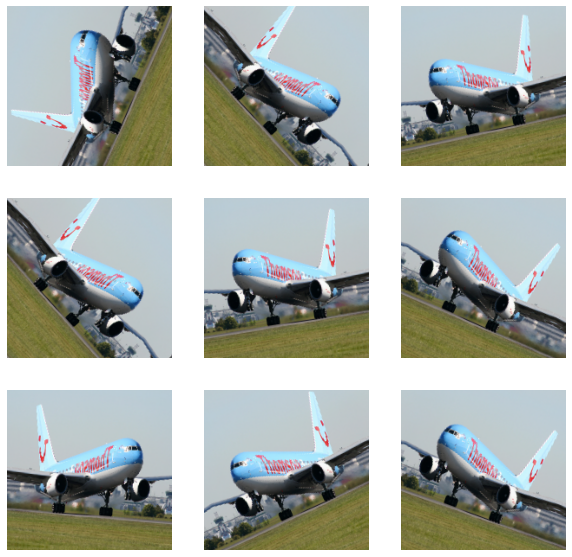

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")        

Prefetching the datasets for .......

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Checking shape of the train dataset

In [11]:
train_ds


<PrefetchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>

Defining the Model.

Augmentation for the input image.

Rescale the images to change the values between 0-255 to 0-1,0.

First  2 layers are regular Conv2D layers.

Afterward a for loop increases the filter size. 

In [12]:
def make_model(input_shape):
 
    inputs = tf.keras.Input(shape=input_shape)
  
    x = data_augmentation(inputs)

    x = layers.Rescaling(1.0 / 255)(x)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x      

    for size in [128, 256, 512, 1024]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 3, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x 
                
        x = layers.SeparableConv2D(1024, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    
    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)

In [13]:
model = make_model(input_shape=image_size + (3,))

Model summary to see the different parameters and trainable neurons.

In [14]:
#model = tf.keras.models.load_model("200_2_save_at_10.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 185, 190, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 185, 190, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 93, 95, 32)   896         ['rescaling[0][0]']          

Plot Model.

In [15]:
#model = tf.keras.models.load_model("200_2_save_at_10.h5")
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Training the model.

In [47]:
epochs = 2

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("200_2_2_save_at_{epoch}.h5"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_ds, epochs=epochs, callbacks=[callbacks, tensorboard_callback], validation_data=val_ds
)

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.


Epoch 1/2
312/312 [==============================] - 1409s 5s/step - loss: 0.0454 - accuracy: 0.9882 - val_loss: 0.0845 - val_accuracy: 0.9776
Epoch 2/2
312/312 [==============================] - 1301s 4s/step - loss: 0.0483 - accuracy: 0.9882 - val_loss: 0.0767 - val_accuracy: 0.9800


In [113]:
from matplotlib import pyplot
model = tf.keras.models.load_model("200_2_save_at_10.h5")

for layer in model.layers:
	# check for convolutional layer
	if 'conv2d_' not in layer.name:	
		continue
	# get filter weights
	#print(layer.name)
	if 'separable' in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)
	
	# normalize filter values to 0-1 so we can visualize them
	f_min, f_max = filters.min(), filters.max()
	filters = (filters - f_min) / (f_max - f_min)

conv2d_1 (3, 3, 32, 64)
conv2d_2 (3, 3, 64, 128)
conv2d_3 (3, 3, 128, 256)
conv2d_4 (3, 3, 256, 512)
conv2d_5 (3, 3, 512, 1024)


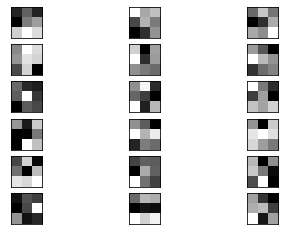

In [114]:
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights.

In [194]:
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)

In [195]:
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

3 conv2d (None, 100, 100, 32)
6 conv2d_1 (None, 100, 100, 64)
10 separable_conv2d (None, 100, 100, 128)
13 separable_conv2d_1 (None, 100, 100, 128)
16 conv2d_2 (None, 50, 50, 128)


In [196]:
img = tf.keras.preprocessing.image.load_img(
    "FighterOrCivil/Civil/2263428.jpg", target_size=image_size
)
img = tf.keras.preprocessing.image.load_img(    
    "MilOrAirline/25.jpg", target_size=image_size)

In [197]:
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

In [198]:
img = preprocess_input(img)

In [199]:
# get feature map for first hidden layer
feature_maps = model.predict(img)

In [200]:
img.shape

(1, 200, 200, 3)

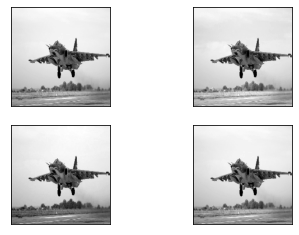

In [216]:
# plot all 64 maps in an 8x8 squares
square = 2
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(img[0, :, :, ix-3], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

In [217]:
"""model = tf.keras.models.load_model("200_2_save_at_10.h5")

#Iterate thru all the layers of the model
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()"""

'model = tf.keras.models.load_model("200_2_save_at_10.h5")\n\n#Iterate thru all the layers of the model\nfor layer in model.layers:\n    if \'conv\' in layer.name:\n        weights, bias= layer.get_weights()\n        print(layer.name, filters.shape)\n        \n        #normalize filter values between  0 and 1 for visualization\n        f_min, f_max = weights.min(), weights.max()\n        filters = (weights - f_min) / (f_max - f_min)  \n        print(filters.shape[3])\n        filter_cnt=1\n        \n        #plotting all the filters\n        for i in range(filters.shape[3]):\n            #get the filters\n            filt=filters[:,:,:, i]\n            #plotting each of the channel, color image RGB channels\n            for j in range(filters.shape[0]):\n                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )\n                ax.set_xticks([])\n                ax.set_yticks([])\n                plt.imshow(filt[:,:, j])\n                filter_cnt+=1\n        p

In [218]:
"""model = tf.keras.models.load_model("200_2_save_at_10.h5")
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input[1], outputs = successive_outputs)

# Convert ht image to Array of dimension (150,150,3)
img = tf.keras.preprocessing.image.load_img(
    "FighterOrCivil/Civil/2263428.jpg", target_size=image_size
)
x   = tf.keras.preprocessing.image.img_to_array(img)
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )"""

'model = tf.keras.models.load_model("200_2_save_at_10.h5")\nsuccessive_outputs = [layer.output for layer in model.layers[1:]]\n#visualization_model = Model(img_input, successive_outputs)\nvisualization_model = tf.keras.models.Model(inputs = model.input[1], outputs = successive_outputs)\n\n# Convert ht image to Array of dimension (150,150,3)\nimg = tf.keras.preprocessing.image.load_img(\n    "FighterOrCivil/Civil/2263428.jpg", target_size=image_size\n)\nx   = tf.keras.preprocessing.image.img_to_array(img)\nx   = x.reshape((1,) + x.shape)\n# Rescale by 1/255\nx /= 255.0\n# Let\'s run input image through our vislauization network\n# to obtain all intermediate representations for the image.\nsuccessive_feature_maps = visualization_model.predict(x)\n# Retrieve are the names of the layers, so can have them as part of our plot\nlayer_names = [layer.name for layer in model.layers]\nfor layer_name, feature_map in zip(layer_names, successive_feature_maps):\n  print(feature_map.shape)\n  if len(f

Defining the plot for the history.

In [44]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    #accuracy
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    #error
    axs[1].plot(history.history["loss"], label="train loss")
    axs[1].plot(history.history["val_loss"], label="test loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss eval")

    plt.show()

Plotting the history of the training.

The axes are accuracy and loss through the epochs.

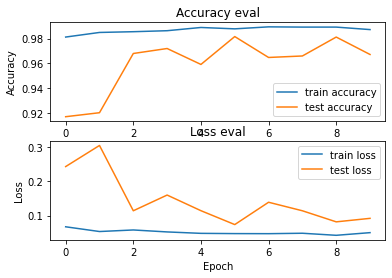

In [45]:
plot_history(history)

Load 10 images for prediction to test the model.

In [16]:
img = tf.keras.preprocessing.image.load_img(
    "FighterOrCivil/Civil/2263428.jpg", target_size=image_size
)
img2 = tf.keras.preprocessing.image.load_img(
    "MilOrAirline/986348976235.jpg", target_size=image_size)
img3 = tf.keras.preprocessing.image.load_img(
    "FighterOrCivil/Civil/0046946.jpg", target_size=image_size)
img4 = tf.keras.preprocessing.image.load_img(
    "FighterOrCivil/Civil/1348803.jpg", target_size=image_size)
img5 = tf.keras.preprocessing.image.load_img(    
    "MilOrAirline/25.jpg", target_size=image_size)
img6 = tf.keras.preprocessing.image.load_img(    
    "FighterOrCivil/Civil/1813989.jpg", target_size=image_size)
img7 = tf.keras.preprocessing.image.load_img(    
    "FighterOrCivil/Civil/a321xlr.jpg", target_size=image_size)
img8 = tf.keras.preprocessing.image.load_img(    
    "FighterOrCivil/Civil/654.jpg", target_size=image_size)
img9 = tf.keras.preprocessing.image.load_img(    
    "FighterOrCivil/Civil/1000.jpg", target_size=image_size)

images = (img, img2, img3,  img4, img5, img6, img7, img8, img9)

images_arrays = []

for imgs in images:
    img_array = tf.keras.preprocessing.image.img_to_array(imgs)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    images_arrays.append(img_array)

Prediction of images.

In [17]:
model = tf.keras.models.load_model("200_2_save_at_10.h5")

for bilder in images_arrays:
    predictions = model.predict(bilder)
    score = predictions[0]

    print(
        "This image is %.2f percent civil and %.2f percent Military aircraft."
        % (100 * (1 - score), 100 * score)
    )

This image is 100.00 percent civil and 0.00 percent Military aircraft.
This image is 1.67 percent civil and 98.33 percent Military aircraft.
This image is 99.78 percent civil and 0.22 percent Military aircraft.
This image is 100.00 percent civil and 0.00 percent Military aircraft.
This image is 0.98 percent civil and 99.02 percent Military aircraft.
This image is 0.01 percent civil and 99.99 percent Military aircraft.
This image is 0.02 percent civil and 99.98 percent Military aircraft.
This image is 77.96 percent civil and 22.04 percent Military aircraft.
This image is 2.45 percent civil and 97.55 percent Military aircraft.


1 = Zivil
2 = Militär
3 = Zivil
4 = Zivil
5 = Militär
6 = Zivil
7 = Zivil
8 = Zivil
9 = Zivil

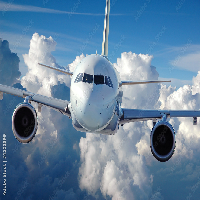

In [109]:
img9

SHAP

In [46]:
shap.initjs()

Turn Dataset into Numpy arrays, as tensors don't seem to be working with shap.

In [16]:
train_dss = train_ds.unbatch()
images = list(train_dss.map(lambda x, y: x))
labels = list(train_dss.map(lambda x, y: y))

print(len(labels))
print(len(images))

9983
9983


In [17]:
train = np.array(images)
train_labels = np.array(labels)

In [18]:
val_dss = val_ds.unbatch()
images_val = list(val_dss.map(lambda x, y: x))
labels_val = list(val_dss.map(lambda x, y: y))

print(len(labels_val))
print(len(images_val))

2495
2495


In [19]:
val = np.array(images_val)
val_labels = np.array(labels_val)

In [20]:
masker = shap.maskers.Image("inpaint_telea", train[0].shape)

In [21]:
class_labels = ["Civil","Military"]

In [22]:
model = tf.keras.models.load_model("200_2_save_at_10.h5")
explainer = shap.Explainer(model, masker, output_names=class_labels)

In [23]:
shap_values = explainer(train[:4], outputs=shap.Explanation.argsort.flip[:1])

shap_values.shape

Partition explainer: 5it [02:01, 30.33s/it]                       


(4, 200, 200, 3, 1)

In [24]:
model = tf.keras.models.load_model("200_2_save_at_10.h5")

probs = model.predict(train[:2])
print("Probabilities : {}".format(np.max(probs, axis=0)))

Probabilities : [1.]


IndexError: index 1 is out of bounds for axis 0 with size 1

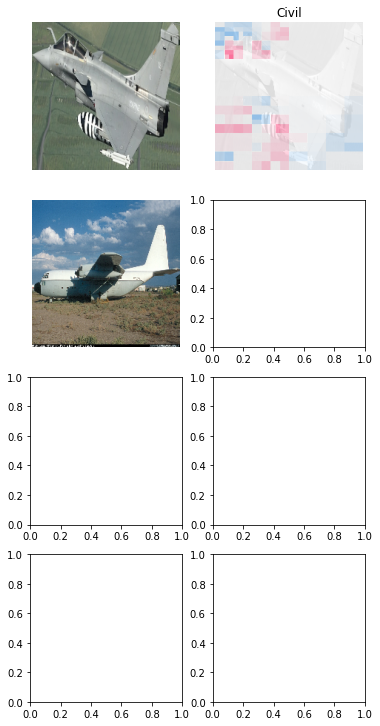

In [62]:
shap.image_plot(shap_values)

This is my alternative code for shap. On my system this results in enormous storage usage while simultaniously freezing the system for around 30 to 40 seconds until a OOM error comes up.

In [19]:
background = train[np.random.choice(train.shape[0], 100, replace=False)]

tf.compat.v1.disable_v2_behavior()
model = keras.models.load_model("200_2_save_at_10.h5")
#e = shap.KernelExplainer(model, background)
#shap_values = e.shap_values(val[1:5])
#shap.image_plot(shap_values, -val[1:5])
e = shap.DeepExplainer(model, background) 

#shap_values = e.shap_values(val[0:1], check_additivity=False)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [31]:
#shap_values = e.shap_values(val[0:1])

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [47]:
#shap.image_plot(shap_values, -val[1:5])

NameError: name 'shap_values' is not defined

Start of Hyperparameter tuning.

In [25]:
input_shape=(200, 200, 3)

In [26]:
train = train.astype('float32') / 255.0
train_labels = train_labels.astype('float32') / 255.0

In [27]:
def model_builder(hp):
  model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=32),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=input_shape),
  # adding second convolutional layer 
  tf.keras.layers.Conv2D(
      #adding filter 
      filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
      #adding filter size or kernel size
      kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
      #activation function
        activation='relu'
    ),
    tf.keras.layers.Conv2D(
      #adding filter 
      filters=hp.Int('conv_5_filter', min_value=512, max_value=1024, step=64),
      #adding filter size or kernel size
      kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
      #activation function
        activation='relu'
    ),
  # adding flatten layer    
  tf.keras.layers.Flatten(),
  # adding dense layer    
  tf.keras.layers.Dense(
      units=hp.Int('dense_1_units', min_value=32, max_value=128, step=32),
      activation='relu'
    ),

  # output layer    
  tf.keras.layers.Dense(10, activation='softmax')
  ])
  #compilation of model
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
  return model



In [28]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=2,
                     factor=2,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [243]:
tuner.search(train, train_labels, epochs=2, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.001.



In [244]:
modelHP = tuner.hypermodel.build(best_hps)
history = modelHP.fit(train, train_labels, epochs=2, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/2
250/250 [==============================] - 2862s 11s/step - loss: 0.0092 - accuracy: 0.4942 - val_loss: 0.0000e+00 - val_accuracy: 0.5048
Epoch 2/2
250/250 [==============================] - 3056s 12s/step - loss: 0.0000e+00 - accuracy: 0.4960 - val_loss: 0.0000e+00 - val_accuracy: 0.5048
Best epoch: 1


In [245]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train, train_labels, epochs=best_epoch, validation_split=0.2)

250/250 [==============================] - 2701s 11s/step - loss: 0.0093 - accuracy: 0.4939 - val_loss: 0.0000e+00 - val_accuracy: 0.5048


In [56]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [57]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 14204), started 1:21:55 ago. (Use '!kill 14204' to kill it.)

In [63]:
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir logs/fit (started 1:23:47 ago; pid 14204)
  - port 6006: logdir /tmp/tb_logs (started 15 days, 1:50:32 ago; pid 15956)
  - port 6006: logdir my_dirintro_to_kt (started 5:13:06 ago; pid 16564)
  - port 6006: logdir my_dir/intro_to_kt (started 5:12:16 ago; pid 18684)
  - port 6006: logdir /logs/fit (started 8 days, 5:54:00 ago; pid 2244)


In [62]:
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir logs/fit (started 1:23:45 ago; port 6006, pid 14204).


In [64]:
input_shapeJo

(200, 200, 3)

In [82]:
def build_modelHP(hp):
    
    modelHP = tf.keras.models.Sequential()
    
    modelHP.add(tf.keras.layers.Flatten(input_shape=(200, 200,3)))
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    modelHP.add(Conv2D(hp_units, 3, input_shape=(200,200,3), strides=2, padding="same"))
    modelHP.add(layers.Flatten(input_shape=(200, 200,3)))
    for i in range(hp.Int("n_layers", 1, 4)):
        modelHP.add(Conv2D(hp.Int(f"conv_{i}_units", 32, 512, 32), 3, input_shape=input_shapeJo, padding="same"))
        modelHP.add(Activation('relu'))

    modelHP.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    modelHP.add(Dense(10))
    #modelHP.add(Activation("softmax"))
    
    activation = "sigmoid"
    units = 1
    
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        modelHP.add(layers.Dropout(rate=0.25))
    modelHP.add(layers.Dense(10, activation="sigmoid"))
    
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    modelHP.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return modelHP

In [83]:
tuner = kt.Hyperband(build_modelHP,
                     objective='val_accuracy',
                     max_epochs=2,
                     factor=3,
                     directory='my_dir',
                     project_name='Planes')

ValueError: Input 0 of layer "conv2d_16" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 120000)

In [125]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
print(tuner.get_best_hyperparameters()[0].values)
print(tuner.get_best_models()[0].summary)